# Examples

---

---Required Modules:

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy.ma as ma
from photutils import detect_sources
from photutils import deblend_sources
import random
from photutils import SourceCatalog
from photutils import CircularAperture
from photutils import aperture_photometry

---

# Example 1

--- In this example you can see how to read an image, apply a mask, and work with an array of pixel values.

In [2]:
image_dir = 'data' # define image directory relative to this script

In [3]:
f = 'f125w' # filter

In [4]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read FITS file data into numpy array

In [5]:
print(f'dimensions of image: {sci.shape}') # print the shape (dimensions) of the image
print(f'total number of pixels (from image): {sci.size}') # total number of real data pixels

dimensions of image: (5250, 5250)
total number of pixels (from image): 27562500


In [6]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask

In [7]:
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our image

In [8]:
pix = sci.flatten() #Â flatten the masked image to produce a list of pixels

In [9]:
print(f'total number of pixels (from masked image): {sci.size}') # total number of real data pixels
print(f'total number of pixels (from masked flattened image): {pix.size}') # total number of real data pixels

total number of pixels (from masked image): 27562500
total number of pixels (from masked flattened image): 27562500


In [10]:
pix = pix[~pix.mask] # remove pixels that were masked

In [11]:
print(f'total number of pixels (from masked flattened image with masked pixels removed): {pix.size}') # total number of real data pixels

total number of pixels (from masked flattened image with masked pixels removed): 4043012


In [12]:
print(f'minimum: {np.min(pix)}') # print the minimum value
print(f'16th percentile: {np.percentile(pix, 16)}') # print the 16th percentile
print(f'median: {np.median(pix)}') # print the median
print(f'84th percentile: {np.percentile(pix, 84)}') # print the 84th percentile
print(f'maximum: {np.max(pix)}') # print the maximum

minimum: -3.3558568954467773
16th percentile: -0.0005067630694247782


C:\Users\Ewan Barclay\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


median: 0.00012366377632133663
84th percentile: 0.0010958873573690651
maximum: 68.6301040649414


---

# Example 2

--- In this example you can see how to obtain a cutout of an image and produce a .png of the cutout.

In [13]:
image_dir = 'data' # define image directory relative to this script

In [14]:
f = 'f125w' # filter

In [15]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read FITS file data into numpy array
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our image

--- calculate the standard deviation of the noise. This is necessary to properly scale the image.

In [16]:
pix = sci.flatten() # flatten the masked image to produce a list of pixels
pix = pix[~pix.mask] # remove pixels that were masked
negpix = pix[pix<0.0] # isolate negative pixels
sigma = -np.percentile(negpix, 31.7) #Â measure \sigma as demonstrated in example1.py.

--- cut out a portion of the image for analysis

In [17]:
x = sci.shape[0] // 2 # pixel x-centre of cutout, must be an integer
y = sci.shape[1] // 2  # pixel y-centre of cutout, must be an integer
r = 150 # width/2 of cutout, must be int

two ways of cutting out, either using a Python slice object

slices = [slice(x-r,x+r,None),slice(y-r,y+r,None)]<br>
centre = sci[slices]

or by simply doing:

In [18]:
centre = sci[x-r:x+r, y-r:y+r]

--- NOW MAKE A PLOT OF THE CUTOUT

without scaling the image or providing limits (vmin, vmax) imshow will automatically scale the image to the largest and smallest values. However, as we saw in example1.py we sometimes have errnously high or low pixels.

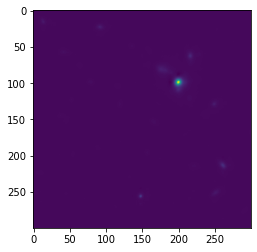

In [19]:
plt.imshow(centre) # no scaling/clipping
plt.show()

there are various things we can do here. For example, we could give imshow a min and max value to map between (any pixel values outside this range will be mapped to end of the colour scale)

In [20]:
vmin = 0
vmax = sigma*20

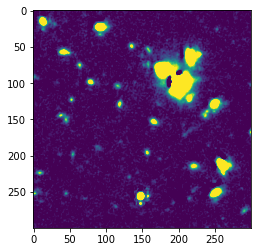

In [21]:
plt.imshow(centre, vmin = vmin, vmax = vmax) # any value >10*sigma will map to the end of the scale
plt.show()

we can also change the default colour map (https://matplotlib.org/examples/color/colormaps_reference.html)

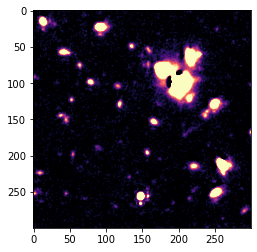

In [22]:
plt.imshow(centre, vmin = vmin, vmax = vmax, cmap = 'magma') # any value >10*sigma will map to the end of the scale
plt.show()

instead of showing images in interactive mode we often want to save a version. By default matplotlib provides space for axes labels etc. The below makes the axes (where the image is plotted) stretch across the full canvas and turns off the frame, ticks, and labels. This also sets the dots-per-inch (dpi) to be the equal to the size of the image in pixels. By setting the size to 1 inch we will then have a figure which is pixel perfect.

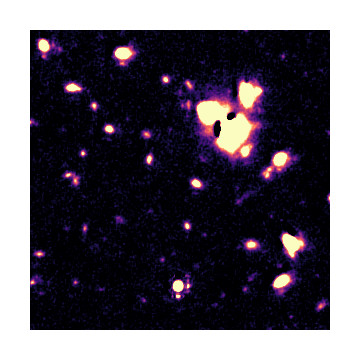

In [23]:
dpi = centre.shape[0] # set dots per inch equal to the number of pixels.
fig = plt.figure(figsize = (1, 1), dpi = dpi)
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(centre, vmin = vmin, vmax = vmax, cmap = 'magma') # shouldn't see much because the scale is dominated by outlier
fig.savefig('XDF_centre_f125w.png')

---

# Example 3

--- In this example you can see how to make a (RBG) colour image by combining images in 3 filters. Incidentally the 3 filters chosen for this example will result in an image that mimics a true colour image. These are the colours you would approximately see!

In [24]:
image_dir = 'data' # define image directory relative to this script

In [25]:
f_RGB = {'R': 'f775w', 'G': 'f606w', 'B': 'f435w'} # define the images corresponding to the RGB channels

In [26]:
im = {channel: fits.getdata(f'{image_dir}/{f}_sci.fits') for channel,f in f_RGB.items()} # read all 3 images into a dictionary

In [27]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask

--- for each image

In [28]:
for channel in 'RGB':
    im[channel] = np.ma.masked_array(im[channel], mask = mask) # apply the mask to our image

    # --- clip negative and erroneously high values and rescale values to be 0 - 1
    # --- NOTE: you can play around here to change the colour balance and contrast of your images
    vmin = 0 # exclude negative values (anything less than vmin gets mapped to vmin)
    vmax =  np.percentile(im[channel][~np.isnan(im[channel])], 99) # exclude the brightest 1% of pixels (anything above gets mapped to that value)
    norm = cm.colors.Normalize(vmin, vmax) # normalisation function
    im[channel] = norm(im[channel]) # apply normalisation function

    # --- set masked values to zero (this makes those pixels black)
    im[channel] = np.ma.filled(im[channel], 0.0) # return masked array with masked values set to 0.0

In [29]:
rgb = np.dstack((im['R'],im['G'],im['B'])) # stack images into a single array

--- make a plot of the full (masked) image and save it

(0.0, 1.0, 0.0, 1.0)

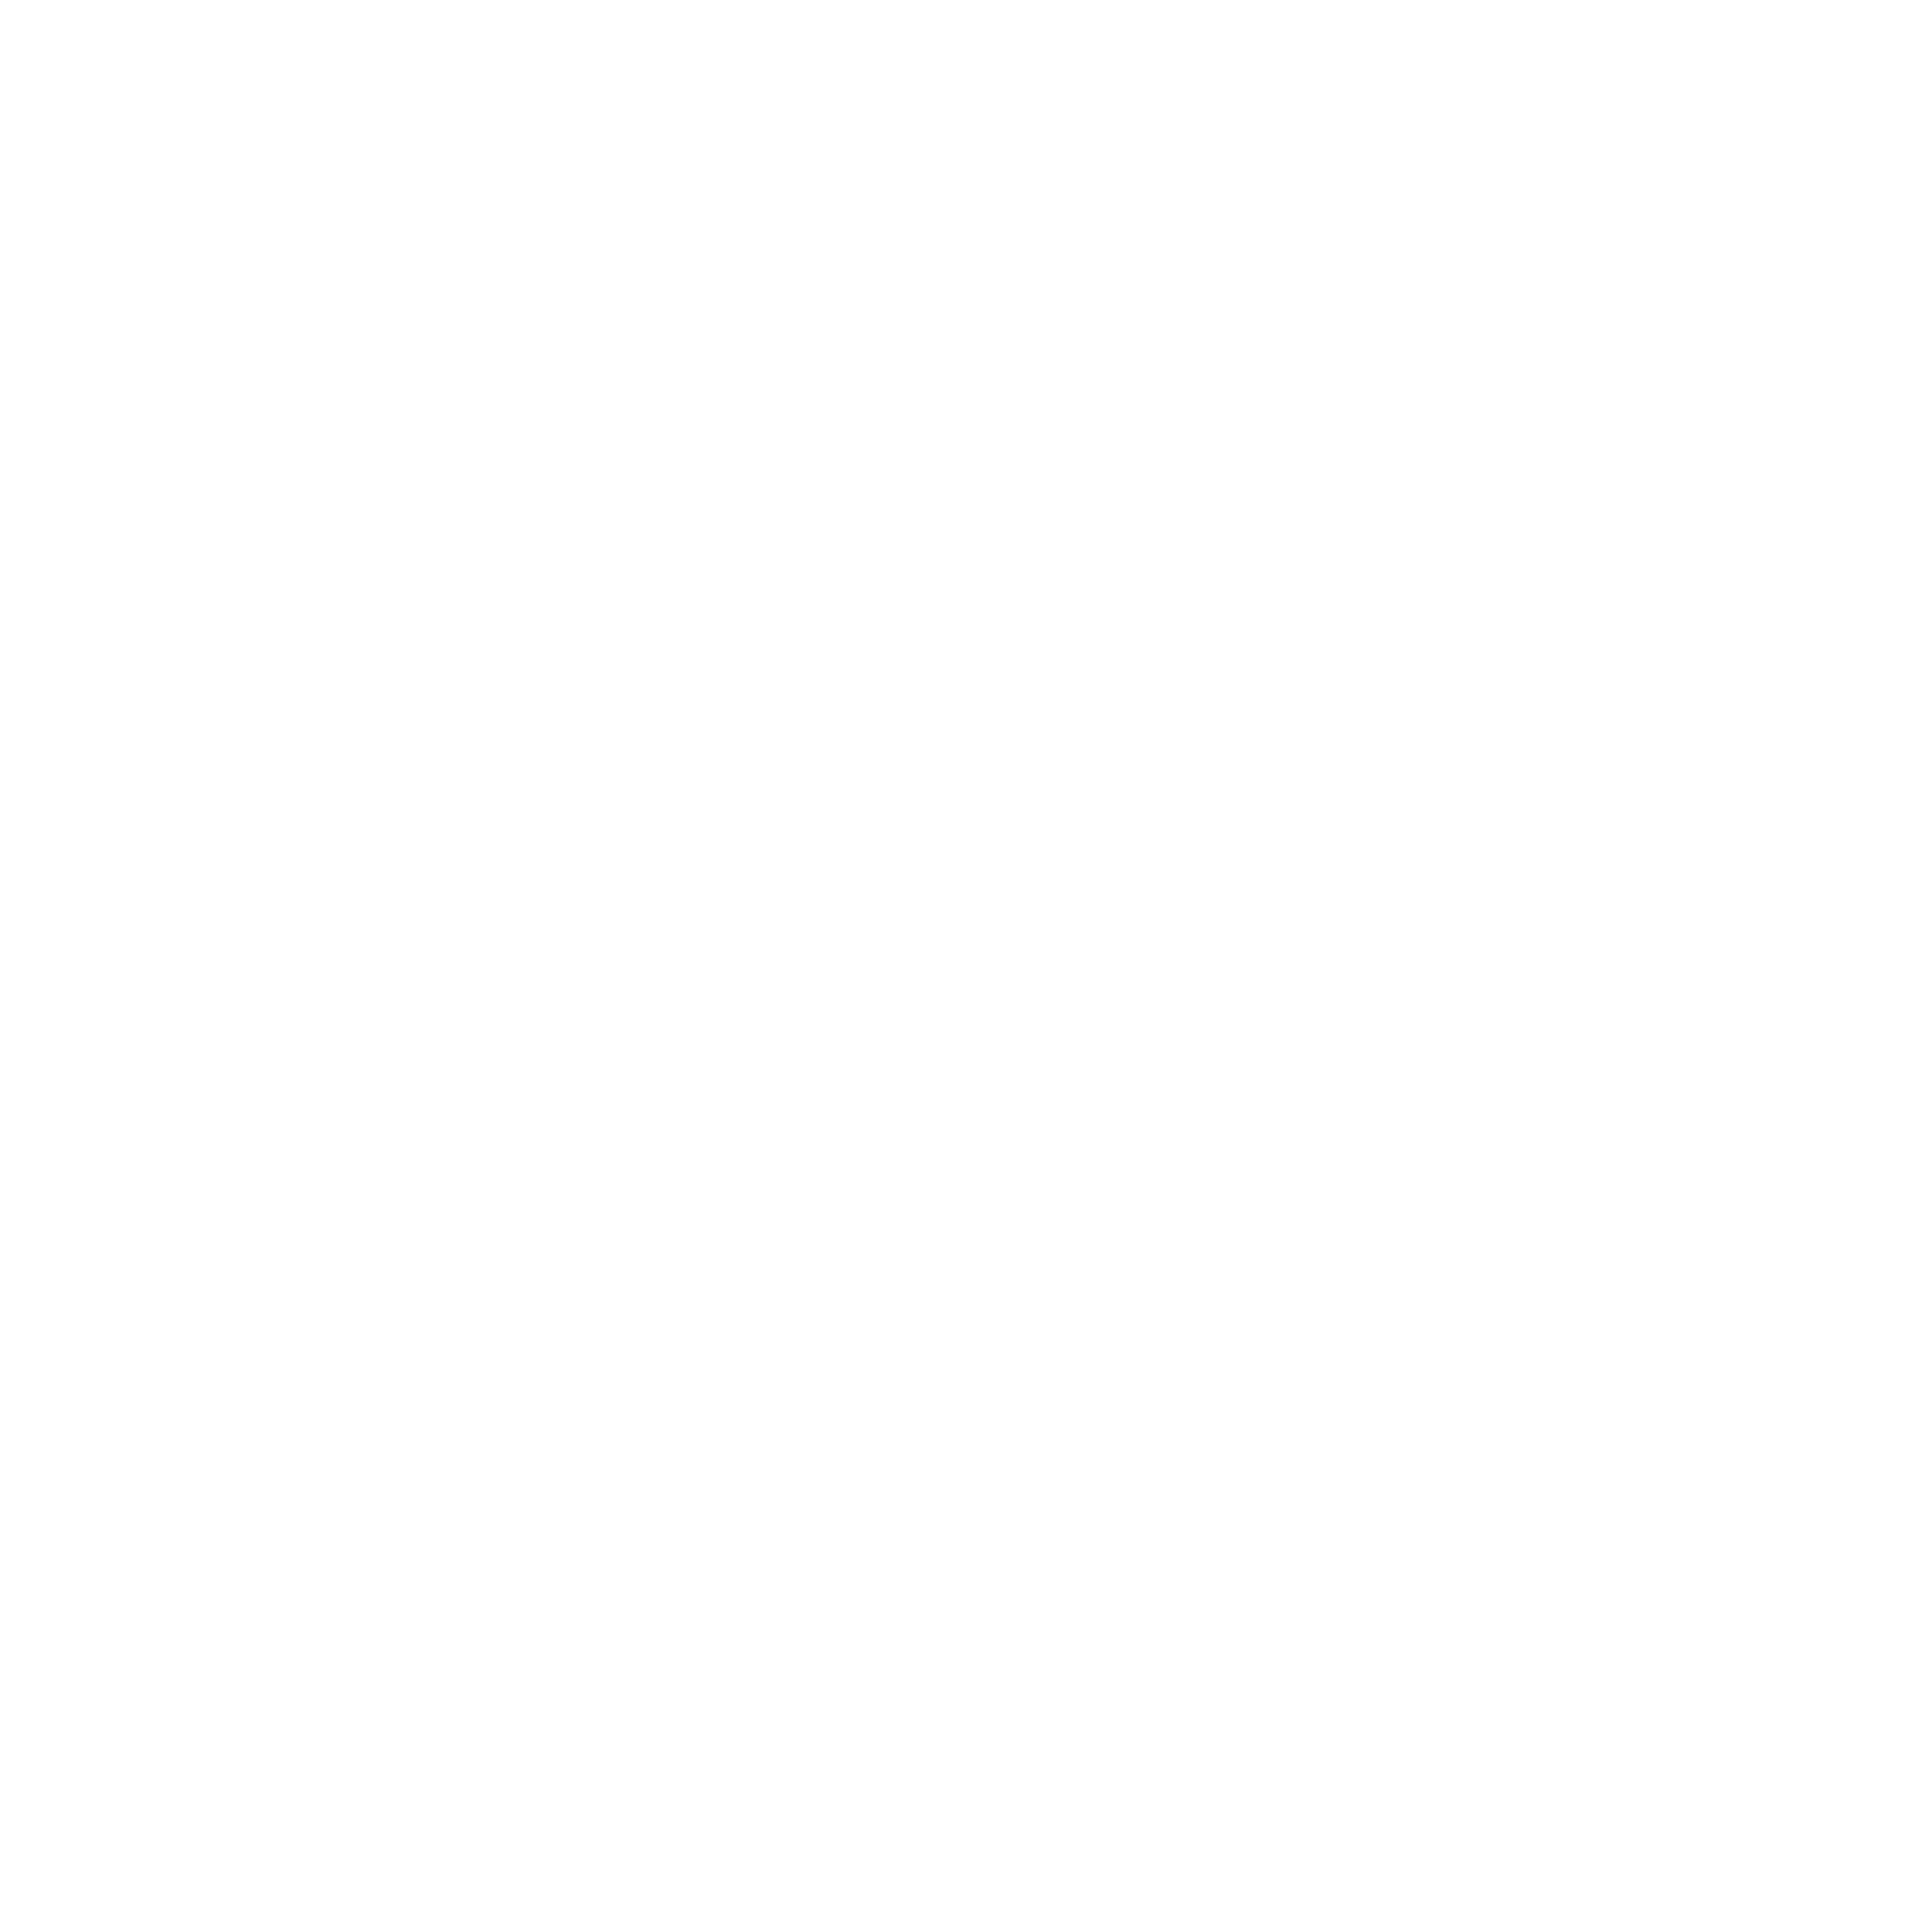

In [30]:
dpi = rgb.shape[0] # set dots per inch equal to the number of pixels.
fig = plt.figure(figsize = (1, 1), dpi = dpi)
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels

In [31]:
ax.imshow(rgb) # shouldn't see much because the scale is dominated by outlier pixels
fig.savefig('XDF_rgb.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--- make a plot of the central 300 pixels of the image

In [32]:
x = rgb.shape[0] // 2 # pixel x-centre of cutout, must be an integer
y = rgb.shape[1] // 2  # pixel y-centre of cutout, must be an integer
r = 150 # width/2 of cutout, must be int

In [33]:
slices = [slice(x-r,x+r,None),slice(y-r,y+r,None)]

In [34]:
centre = rgb[slices]

<ipython-input-34-b387f5432c31>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  centre = rgb[slices]


(0.0, 1.0, 0.0, 1.0)

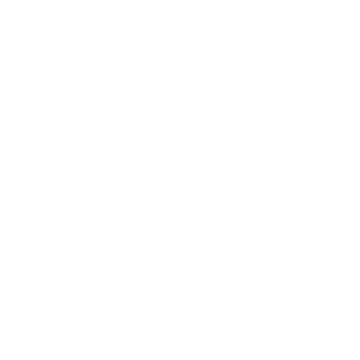

In [35]:
dpi = centre.shape[0] # set dots per inch equal to the number of pixels.
fig = plt.figure(figsize = (1, 1), dpi = dpi)
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels

In [36]:
ax.imshow(centre) # shouldn't see much because the scale is dominated by outlier pixels
fig.savefig('XDF_centre_rgb.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


---

# Example 4

#### --- In this example you will learn to approproately combine (stack) different images

In [37]:
save = False

--- combine (stack) a list of images together

In [38]:
image_dir = 'data' # image directory relative to this script

In [39]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask

In [40]:
filters = ['f435w','f606w'] # list of images to combine (stack)

In [41]:
sci = {f: fits.getdata(f'{image_dir}/{f}_sci.fits') for f in filters} # read sci images
wht = {f: fits.getdata(f'{image_dir}/{f}_wht.fits') for f in filters} # read weight images

In [42]:
shape = next(iter(sci.values())).shape
combined_sci = np.zeros(shape)   #create empty array to fill combined sci/wht images
combined_wht = np.zeros(shape)  

In [43]:
for f in filters:                    #combine images from different filters
    combined_sci += sci[f] * wht[f]
    combined_wht += wht[f]

--- NOTE: this image can be used "as-is" or saved as a numpy array and read in later. To read back in simply use "array = np.load(filename)"

In [44]:
if save:
    filename = '_'.join(filters)
    np.save(f'{filename}_sci.npy', combined_sci)
    np.save(f'{filename}_wht.npy', combined_wht)

---

# Example 5

--- Building on example 2 in this example you will also use the weight (wht) map to obtain an estimate of the significance of each pixel.

In [45]:
image_dir = 'data' # define image directory relative to this script

In [46]:
f = 'f125w' # filter

In [47]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [48]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [49]:
x = sci.shape[0] // 2 # pixel x-centre of cutout, must be an integer
y = sci.shape[1] // 2  # pixel y-centre of cutout, must be an integer
r = 150

In [50]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [51]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- plot the cutout significance map

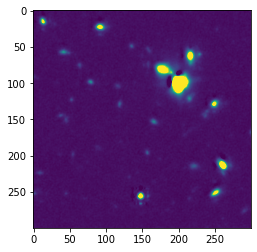

In [52]:
plt.imshow(sig, vmin=-2, vmax = 50) # set scale so max significance is 50
plt.show()

--- the above figure can be improved by using two difference scales: one for pixels sig<2 and one for those above. This nicely highlights pixels above some noise threshold. To do this we first plot the map with sig<2 and then plot a masked image o pixels with sig>threshold

In [53]:
threshold = 2

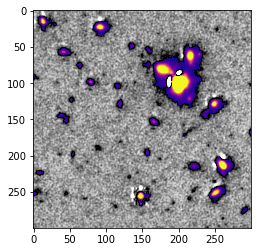

In [54]:
plt.imshow(sig, vmin = -threshold, vmax = threshold, cmap = 'Greys')
plt.imshow(np.ma.masked_where(sig <= threshold, sig), cmap = 'plasma', vmin = threshold, vmax = 50)
plt.show()

version to save

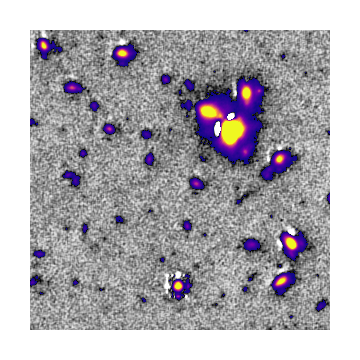

In [55]:
fig = plt.figure(figsize = (1, 1), dpi = sig.shape[0])
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(sig, vmin = -threshold, vmax = threshold, cmap = 'Greys')
ax.imshow(np.ma.masked_where(sig <= threshold, sig), cmap = 'plasma', vmin = threshold, vmax = 50)
fig.savefig('significance.png')

---

# Example 6 

--- In this example we run segmentation on a significance image to identify sources.

In [56]:
image_dir = 'data' # define image directory relative to this script

In [57]:
f = 'f125w' # filter

In [58]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [59]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [60]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [61]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [62]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image. Segmentation identifies groups of connected pixels which are all above some threshold.

In [63]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [64]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

In [65]:
print(f'total number of sources in original map: {segm.max_label}')
# print(f'total number of sources in original map: {segm.nlabels}') # also works
# print(f'total number of sources in original map: {np.max(segm.data)}') # also works

total number of sources in original map: 20


The segmentation image has the same dimensions as the input image. Each pixel in the segmentation image has an integer value. If $p_{i,j}=0$ this means that pixel isn't associated with a source. If $p_{i,j}>0$ that pixel is part of an object. Using imshow on the segmentation map will automatically colour each image by a different colour.

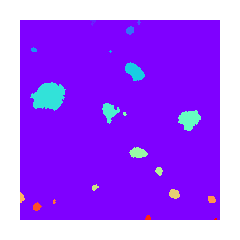

In [66]:
fig = plt.figure(figsize = (1, 1), dpi = segm.data.shape[0])
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(segm, cmap = 'rainbow')
plt.show()
fig.savefig('segm.png')

If two sources overlap simple segmentation can merge them together. This can be over-come using de-blending

In [67]:
segm_deblend = deblend_sources(sig, segm, npixels=npixels, nlevels=32, contrast=0.001)

In [68]:
print(f'total number of sources in debelended map: {segm_deblend.max_label}')

total number of sources in debelended map: 24


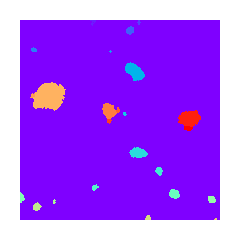

In [69]:
fig = plt.figure(figsize = (1, 1), dpi = segm_deblend.data.shape[0])
ax = fig.add_axes((0.0, 0.0, 1.0, 1.0)) # define axes to cover entire field
ax.axis('off') # turn off axes frame, ticks, and labels
ax.imshow(segm_deblend, cmap = 'rainbow')
plt.show()
fig.savefig('segm_deblend.png')

---

# Example 7

--- In this example we look at the properties of one of the sources identified by segmentation.

In [70]:
image_dir = 'data' # define image directory relative to this script

In [71]:
f = 'f125w' # filter

In [72]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [73]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [74]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [75]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [76]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image.

In [77]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [78]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

In [79]:
unique, counts = np.unique(segm.data, return_counts=True)

In [80]:
print(unique)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[37929    18    12    54    23     5   235   707   199   318    12   147
    49    30    84    36    49    11    53    24     5]


--- let's now plot the segmentation map but only for a single source

segm.data is the segmentation map. In this map pixels are labelled as either "0" if they are part of the background (i.e. not associated with a source) or >0 if they belong to a source. Each discrete object has a different number.

i = 11 # this corresponds to the 11th object NOT the 12th. The 0 (zero) index corresponds to the background. The choice of object 11 is completely arbitrary.

In [81]:
i = random.randint(1, segm.nlabels) # choose a random object
#eg:
i = 11

In [82]:
masked_segm = np.ma.masked_where(segm.data != i, segm) # mask all pixels except object i

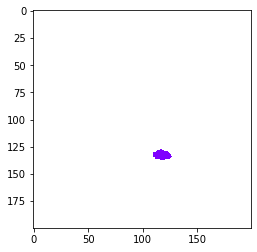

In [83]:
plt.imshow(masked_segm, cmap = 'rainbow') # plot masked segmentation map
plt.show()

--- let's now plot the science (flux) map but only for the same single source

In [84]:
masked_sci = np.ma.masked_where(segm.data != i, sci)

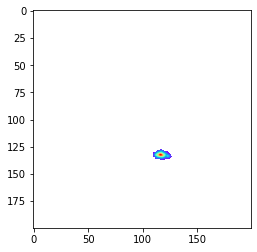

In [85]:
plt.imshow(masked_sci, cmap = 'rainbow') # plot masked segmentation map
plt.show()

--- instead of plotting the entire image we can plot a zoom in of the object we want. To do this we can use the slice provided by segmentation object

In [86]:
slices = segm.slices[i-1] # a pair of python slice objects NOTE: the -1 is necessary as slices are only provided for objects not the background. The first object would be segm.slices[0] NOT segm.slices[1] because of python indexing convention. BE CAREFUL.

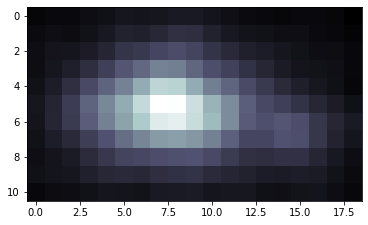

In [87]:
plt.imshow(sci[slices], cmap = 'bone') # apply slice to science image
plt.show()

--- now lets determine the total flux of that same source by simply summing the pixels

we could simply sum the masked science image (masked_sci):

In [88]:
print(f'signal using masked science image: {np.sum(masked_sci)}')

signal using masked science image: 1.711333990097046


or, avoiding previous steps only sum pixels on the orginal science image where the segmentation map = the index of our target galaxy:

In [89]:
print(f'signal using science image + np.where command on segmentation map: {np.sum(sci[np.where(segm.data==i)])}')

signal using science image + np.where command on segmentation map: 1.711333990097046


---

# Example 7a

--- In this example we look at the properties of one of the sources identified by segmentation.

In [90]:
image_dir = 'data' # define image directory relative to this script

In [91]:
f = 'f125w' # filter

In [92]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [93]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [94]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [95]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [96]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image.

In [97]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [98]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

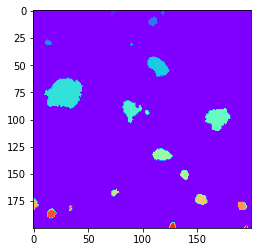

In [99]:
plt.imshow(segm, cmap = 'rainbow') # plot masked segmentation map
plt.show()

--- calculate object positions

In [100]:
cat = SourceCatalog(sci, segm)
positions = [np.transpose((obj.xcentroid, obj.ycentroid)) for obj in cat]

--- display single object

In [101]:
i = 8

In [102]:
mask = ~((segm.data==i)|(segm.data==0)) # only background + object
# mask = segm.data!=i # only object
masked_segm = np.ma.array(segm, mask = mask) # mask all pixels except object i

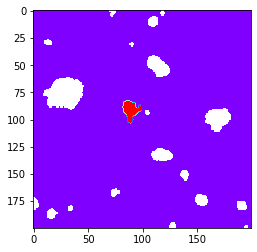

In [103]:
plt.imshow(masked_segm, cmap = 'rainbow') # plot masked segmentation map
plt.show()

In [104]:
radii = np.arange(1,21,1)
apertures = [CircularAperture(positions[i-1], r=r) for r in radii]

In [105]:
phot_table = aperture_photometry(sci, apertures, mask = mask)
print(phot_table)

 id      xcenter           ycenter      ...  aperture_sum_18   aperture_sum_19  
           pix               pix        ...                                     
--- ----------------- ----------------- ... ----------------- ------------------
  1 88.60878709373883 90.44619219580102 ... 4.350220716379615 4.3722783505714755


---

# Example 8

--- In this example we look at the properties of one of the sources identified by segmentation.

In [106]:
image_dir = 'data' # define image directory relative to this script

In [107]:
f = 'f125w' # filter

In [108]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [109]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [110]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [111]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [112]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image.

In [113]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [114]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

In [115]:
i = 11

--- lets again determine the total flux of that same source by simply summing the pixels on the orginal science image where the segmentation map = the index of our target galaxy:

In [116]:
signal = np.sum(sci[np.where(segm.data==i)])

In [117]:
print(f'the signal is: {signal}')

the signal is: 1.711333990097046


--- the signal alone isn't very useful, we need an estimate of the uncertainty or error. The error is the sqrt(sum(noise_i**2))

In [118]:
error = np.sqrt(np.sum(noise[np.where(segm.data==i)]**2))

In [119]:
print(f'the error (noise) is: {error}')
print(f'the signal-to-noise is: {signal/error}')

the error (noise) is: 0.016436539590358734
the signal-to-noise is: 104.11766052246094


---

# Example 9

--- In this example we look at aperture photometry.

In [120]:
image_dir = 'data' # define image directory relative to this script

In [121]:
f = 'f125w' # filter

In [122]:
sci = fits.getdata(f'{image_dir}/{f}_sci.fits') # read science FITS file data into numpy array
wht = fits.getdata(f'{image_dir}/{f}_wht.fits') # read weight FITS file data into numpy array

In [123]:
mask = fits.getdata(f'{image_dir}/mask.fits') # read in the image mask
sci = np.ma.masked_array(sci, mask = mask) # apply the mask to our science image
wht = np.ma.masked_array(wht, mask = mask) # apply the mask to our weight image

--- cut out a portion of the image for analysis

In [124]:
x = 2500 # pixel x-centre of cutout, must be an integer
y = 2500 # pixel y-centre of cutout, must be an integer
r = 100 # width/2 of cutout, must be int

In [125]:
sci = sci[x-r:x+r, y-r:y+r] # cutout a portion of the science image
wht = wht[x-r:x+r, y-r:y+r] # cutout a portion of the weight image

--- define the noise in each pixel and make a significance map (signal/noise)

In [126]:
noise = 1./np.sqrt(wht) #Â conversion from weight to noise
sig = sci/noise # signifance map

--- now run segmentation on the image to detect sources.

In [127]:
threshold = 2.5 # require each pixel have a significance of >2.5 (since we're using the significance image)
npixels = 5 # require at least 5 connected pixels

In [128]:
segm = detect_sources(sig, threshold, npixels=npixels) # make segmentation image

--- get various properties of the sources, crucially inclusing their centres

In [129]:
cat = SourceCatalog(sci, segm)

--- get a list of positions (x,y) of the sources

In [130]:
positions = []
for obj in cat:
    positions.append(np.transpose((obj.xcentroid, obj.ycentroid)))

--- make a CircularAperture object. This can be plotted but is mostly used for the aperture photometry.

In [131]:
r = 5. # radius of aperture in pixels
apertures = CircularAperture(positions, r)

--- let's make a plot of the sources and the apertures

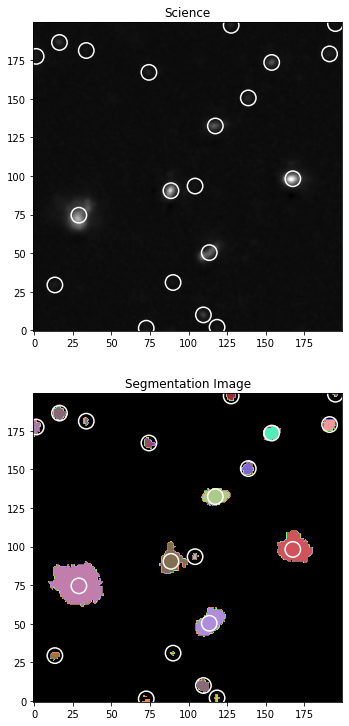

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(sci, origin='lower', cmap='Greys_r')
ax1.set_title('Science')
cmap = segm.make_cmap()
ax2.imshow(segm, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')
for aperture in apertures:
    aperture.plot(axes=ax1, color='white', lw=1.5)
    aperture.plot(axes=ax2, color='white', lw=1.5)
plt.show()

--- now let's do some photometry

In [133]:
phot_table = aperture_photometry(sci, apertures)
phot_table['aperture_sum'].info.format = '%.3f'  # for consistent table output
print(phot_table)

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1   72.6228960075881  1.410878628183665        0.156
  2  118.4863224799657 2.0495154963363813        0.137
  3 109.62743939853789 10.034575718885554        0.576
  4 13.456862649677296 29.414014725391073        0.215
  5  89.99568588379249 31.002968211487428        0.100
  6 113.42877106258788 50.358947483678705        2.036
  7  29.00284826120116  74.59168080669345        4.013
  8  88.60878709373883  90.44619219580102        3.030
  9 167.52983458532634  98.18594132652123        4.651
 10 104.23501637791564  93.46704197272467        0.173
 11 117.36675817217618 132.37865612646942        1.255
 12 138.69676344522188 150.52624427073053        0.396
 13   74.3525677920319 167.09040776118465        0.283
 14 153.85252765833738  173.5001018128976        0.936
 15 1.3405129824934536 177.43326890619403        0.246
 16 191.33

---

# Example 10

--- In this example we simply carry out a conversion from signal (e/s) to flux. In this case we simply assume the same signal in every band.

In [134]:
nJy_to_es = {'f435w': 0.005171303179169625, 'f606w': 0.011015393095414123, 'f775w': 0.005142804319487919, 'f814w': 0.0066619290022345385, 'f850lp': 0.0024366884234595892, 'f105w': 0.008863392873279346, 'f125w': 0.008550667128846823, 'f140w': 0.010490592077764458, 'f160w': 0.006582638416409025}

In [135]:
filters = ['f435w','f606w', 'f775w','f814w', 'f850lp', 'f105w','f125w','f140w','f160w']

In [136]:
signal = 0.01 # e/s

In [137]:
for f in filters:
    print(f'flux/nJy: {signal/nJy_to_es[f]}')

flux/nJy: 1.9337485452952572
flux/nJy: 0.907820530178188
flux/nJy: 1.9444644164481304
flux/nJy: 1.5010667325703724
flux/nJy: 4.103930524610154
flux/nJy: 1.1282361216489916
flux/nJy: 1.1694993910198723
flux/nJy: 0.9532350439205141
flux/nJy: 1.5191476984475203


---